In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scipy.stats as stats
from src.SMT_Analysis_BP.helpers.NND import nearest_neighbour_distances_2d, pairwise_array

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_31060/2294760254.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [5]:
#load a tif file with 5000 frames
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


#load the tif file
data = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/laco_laci_ez_1_seg.tif')
print(data.shape)



(5000, 290, 292)


(1250.0, 1290.0)

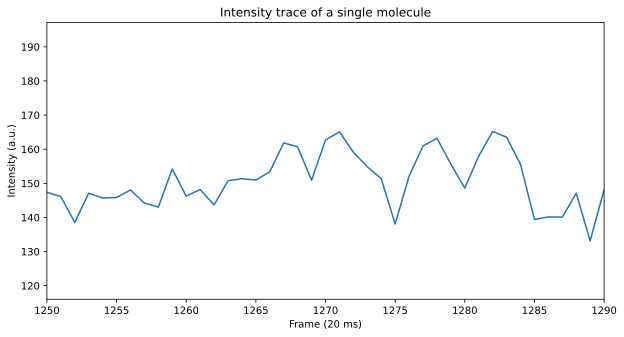

In [35]:
#find the intensity at (:,174,186) but average over a 2x2 pixel area
intensity = []
for i in range(5000):
    intensity.append(np.mean(data[i,185:189,173:178]))
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(intensity)
ax1.set_xlabel('Frame (20 ms)')
ax1.set_ylabel('Intensity (a.u.)')
ax1.set_title('Intensity trace of a single molecule')

#confine to +-10 frames at 1000
ax1.set_xlim(1270-20,1270+20)


In [ ]:
#plot the first frame
plt.imshow(data[10,:,:],cmap='gray')
plt.show()


In [ ]:
#threshold all the frames and plot the first frame
data_th = data > 150
#make the values integers
data_th = data_th.astype(int)
#check the intensity values of the first frame
print(data_th[0,0:10,0:10])


In [ ]:
#find regions of interest using regionprops
#before using regionprops, dilate the image to make the regions more visible
from skimage import measure
#use labels to connect the regions
labels_th = measure.label(data_th[1500,:,:],connectivity=2,background=140)
regions = measure.regionprops(labels_th)
print(len(regions))

#plot the 126th frame with the regions of interest
plt.imshow(data[1500,:,:],cmap='gray')
plt.show()

#plot the regions of interest along with the original image
fig, ax = plt.subplots()
ax.imshow(data_th[1500,:,:], cmap=plt.cm.gray)
for props in regions:
    #ignore regions with only 2 pixels
    if props.area > 2:
        #plot the regions with a red boundary
        y0, x0 = props.centroid
        ax.plot(x0, y0, 'ro', fillstyle='none')
plt.show()





In [ ]:
#apply this to the entire stack of images
#find the centroids of all the regions of interest
#make a dataframe to store the centroids
df = pd.DataFrame(columns=['frame','x','y'])
#loop over all the frames
for i in range(0,data.shape[0]):
    #find the regions of interest
    labels_th = measure.label(data_th[i,:,:],connectivity=2,background=160)
    regions = measure.regionprops(labels_th)
    #loop over all the regions of interest
    for props in regions:
        #ignore regions with only 2 pixels
        if props.area > 2:
                
            y0, x0 = props.centroid
            #use concat to add the new row to the dataframe
            df = pd.concat([df,pd.DataFrame([[i,x0,y0]],columns=['frame','x','y'])])


In [ ]:
#plot the centroids as a function of time
plt.plot(df['frame'],df['x'],'b+',label='x')
plt.plot(df['frame'],df['y'],'r.',label='y')
plt.legend()
plt.xlabel('frame')
plt.ylabel('centroid')
#plt.ylim(174,176)
plt.show()

#for the first 10 frames plot the centroids along with the original image
for i in range(0,10):
    fig, ax = plt.subplots()
    ax.imshow(data[i,:,:], cmap=plt.cm.gray)
    #plot the centroids for the ith frames using df and the frame number
    ax.plot(df[df['frame']==i]['x'], df[df['frame']==i]['y'], 'ro', fillstyle='none')
    
    plt.show()
#on a different plot, get the Rvalues (x^2+y^2)^(1/2) for each frame and plot that as a function of time
df['R'] = np.sqrt(df['x']**2 + df['y']**2)
plt.plot(df['frame'],df['R'],'b+',label='R')
plt.legend()
plt.xlabel('frame')
plt.ylabel('R')
plt.show()






In [ ]:
#allow inline plotting
%matplotlib inline
#for each region found in frame 126, create a 3x3 pixel mask around the centroid and display the original image
#find the ceteroid of the region of interest from the df 
x0 = df[(df['frame']==10) & (df['x']>0) & (df['y']>0)]['x'].values[0]
y0 = df[(df['frame']==10) & (df['x']>0) & (df['y']>0)]['y'].values[0]
#make a mask around the centroid
#subtract the background value we thresholded before
mask = data[126,int(y0-3):int(y0+3),int(x0-3):int(x0+3)]
#plot the mask
plt.imshow(mask-100,cmap='gray')
plt.show()



In [ ]:
#fit a 2D gaussian to the mask
#make a meshgrid of the size of the mask
x = np.arange(0,6,1)
y = np.arange(0,6,1)
X,Y = np.meshgrid(x,y)
#flatten the mask
Z = mask.ravel()
X,Y = X.ravel(),Y.ravel()
#fit a 2D gaussian to the mask
def gaussian2D(XY, a, x0, y0, sigma_x, sigma_y, offset):
    (x,y) = XY
    return a*np.exp(-(x-x0)**2/(2*sigma_x**2) - (y-y0)**2/(2*sigma_y**2)) + offset
#use the maximum value of the mask as the initial guess for the amplitude, the centroid as the initial guess for the center, and 1 for the initial guess for the sigma
popt,pcov = curve_fit(gaussian2D,(X,Y),Z,p0=[np.max(Z),0,0,1,1,np.min(Z)])

print("I: %5.3f, x0: %5.3f, y0: %5.3f, sigma_x: %5.3f, sigma_y: %5.3f, offset: %5.3f" % tuple(popt))

#plot the original image with the x0 and y0 values as a red cross
plt.imshow(data[126,:,:],cmap='gray')
plt.plot(df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['x'], df[(df['frame']==126) & (df['x']>0) & (df['y']>0)]['y'], 'ro', fillstyle='none')
plt.show()








In [ ]:
#Lets apply this to all the frames using the already made dataframe
#for each frame find the centroid of each region of interest and make a mask around it and fit a 2D gaussian to it

#store the fit parameter data in a dataframe
df_fit = pd.DataFrame(columns=['frame','I','x0','y0','sigma_x','sigma_y','offset'])

for i in range(data.shape[0]):
    #find all the x0,y0 values for the ith frame 
    x0 = df[(df['frame']==i) & (df['x']>0) & (df['y']>0)]['x'].values
    y0 = df[(df['frame']==i) & (df['x']>0) & (df['y']>0)]['y'].values
    #loop over all the regions of interest
    for j in range(len(x0)):
        #create a 3x3 mask around the centroid
        mask = data[i,int(y0[j]-3):int(y0[j]+3),int(x0[j]-3):int(x0[j]+3)]
        #fit a 2D gaussian to the mask
        #make a meshgrid of the size of the mask
        x = np.arange(0,6,1)
        y = np.arange(0,6,1)
        X,Y = np.meshgrid(x,y)
        #flatten the mask
        Z = mask.ravel()
        X,Y = X.ravel(),Y.ravel()
        #fit a 2D gaussian to the mask which is the same as before
        popt,pcov = curve_fit(gaussian2D,(X,Y),Z,p0=[np.max(Z)-120,x0[j],y0[j],1,1,120])
        #use concat to add the new row to the dataframe
        df_fit = pd.concat([df_fit,pd.DataFrame([[i,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]]],columns=['frame','I','x0','y0','sigma_x','sigma_y','offset'])])

        
    

In [ ]:
#plot the histrogram of the intensity alongside the offset and label them
plt.hist(df_fit['I']+df_fit['offset'],bins=100)
plt.hist(df_fit['offset'],bins=100)
plt.legend(['Intensity','Offset'])
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Peak Intensity Histogram for the 2D Gaussian Fit \n with the offset')
plt.show()

#replot the histogram after subtracting the offset
plt.hist(df_fit['I'],bins=80)
plt.xlabel('Background Subtracted Intensity')
plt.ylabel('Counts')
plt.title('Peak Intensity Histogram for the 2D Gaussian Fit \n corrected with offset')
plt.show()

#print mean I+offset and mean pffset
print('Mean I+offset: %5.3f' % np.mean(df_fit['I']+df_fit['offset']))
print('Mean offset: %5.3f' % np.mean(df_fit['offset']))



In [ ]:
x = np.abs(df_fit['x0']-100)
y = np.abs(df_fit['y0']-100)
#print the mean and standard deviation of the x0 and y0 values
print('Mean x0: %5.3f' % np.mean(x))
print('Mean y0: %5.3f' % np.mean(y))
print('Standard Deviation x0: %5.3f' % np.std(x))
print('Standard Deviation y0: %5.3f' % np.std(y))


In [ ]:
#plot the historgram of the sigma_x and sigma_y values
plt.hist(df_fit['sigma_x'],bins=100)
plt.hist(df_fit['sigma_y'],bins=100)
plt.legend(['sigma_x','sigma_y'])
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the 2D Gaussian Fit')
plt.show()


To calculate the static localization use static_localization_error = Peak_Intensity_Corrcted*2pi *(PSF_sigma/pixel_size)^2 

To calculate the dynamic localization for a set diffuion D:
integration time = t
dynamic_loc_error = static_localization_error * sqrt(1 + D*t/(PSF_sigma^2))
#for a localization error of 0.08um, D= 0.01um^2/s, t= 20ms, PSF_sigma= 0.1um
static_localization error  = 0.00816um^2/s

for D = 0.1um^2/s and all the rest same:
static_localization error  = 0.0096um^2/s

for D = 0.1um^2/s and all the rest same:
static_localization error  = 0.0096um^2/s

for D = 1um^2/s and all the rest same:
static_localization error  = 0.024um^2/s


In [ ]:
#find the localization error using the follow formula: loc_err = sqrt(sigma_x^2 + sigma_y^2)/(sqrt((I-offset)*2*pi))
#store the localization error in a new column in the dataframe
#one pixel is 130 nm so the localization error is in nm
df_fit['loc_err'] = np.sqrt(df_fit['sigma_x']**2 + df_fit['sigma_y']**2)/(np.sqrt((df_fit['I']-df_fit['offset'])*2*np.pi))*130
#plot the histogram of the localization error
plt.hist(df_fit['loc_err'],bins=50)
plt.xlabel('Localization Error')
plt.ylabel('Counts')
plt.title('Localization Error Histogram for the 2D Gaussian Fit')
plt.show()


LacI


In [ ]:
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
#import io from skimage import io
from skimage import io

detection_args = {"median":False,
                "threshold":4e-4, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":2./np.sqrt(2),
                "num_sigma":10,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":5,
                "centeroid_range":0.5,
                "height_range":20}
#load the tif file
data = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/laco_laci_ez_1_seg.tif')
print(data.shape)
#get the first frame of the data
frame = data[950,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [ ]:
#for all images find the blobs and store the data in a dataframe
df_blob = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])

for i in range(data.shape[0]):
    if i%1 == 0:
        #get the frame
        frame = data[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            x_stderr = j.params["centroid_x"].stderr
            y = j.params["centroid_y"].value
            y_stderr = j.params["centroid_y"].stderr
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130./(np.sqrt((I)*2*np.pi))
            df_blob = pd.concat([df_blob,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err,x_stderr,y_stderr]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])])

        


In [ ]:
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture

#ccreate a new df to store only the entries which have a sigma_x and sigma_y value larger than 1/sqrt(2) to correct for Scale space approach used (erronous blobs)
df_blob_filtered = df_blob[(df_blob['sigma_x'] > 0.1/np.sqrt(2)) & (df_blob['sigma_y'] > 0.1/np.sqrt(2))]
#do a GMM fit to the localization error without including Nan and inf values

#gmm = GaussianMixture(n_components=1).fit(df_blob_filtered['loc_err'].values.reshape(-1,1))
#do a KDE fit to the localization error
#kde = gaussian_kde(df_blob_filtered['loc_err'].values.reshape(-1,1))


#plot the histogram of the localization error
plt.hist(df_blob_filtered['loc_err'].values,bins=50,density=True)
#plot the mean line with annotation in the form "Static Localization Error = {} nm", and make the text near the top of the plot
plt.axvline(df_blob_filtered['loc_err'].mean(),color='r')
plt.annotate("Static Localization Error = {} nm".format(round(df_blob_filtered['loc_err'].mean(),2)),xy=(df_blob_filtered['loc_err'].mean(),0.0005),xytext=(df_blob_filtered['loc_err'].mean(),0.001),arrowprops=dict(facecolor='black', shrink=0.05))


#plot the KDE line
#plt.plot(np.linspace(4,15,100),kde(np.linspace(4,15,100)))

plt.xlabel('Localization Error')
plt.ylabel('Density')
plt.title('Localization Error Histogram for the Blob Detection')
plt.show()

#plot the histogram of the intensity
plt.hist(df_blob_filtered['I'].values + df_blob_filtered['offset'].values,bins=50,label="Signal + Background")
plt.hist(df_blob_filtered['offset'].values,bins=50,label="Background")
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Intensity Histogram for the Blob Detection')
plt.legend()
plt.show()



#plot the histogram of the intensity
plt.hist(df_blob_filtered['I'].values,bins=50)

plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Intensity Histogram for the Blob Detection')
plt.show()


#plot the psf of the blob detection
plt.hist(df_blob_filtered['sigma_x'].values,bins=50)
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()


#plot the psf of the blob detection
plt.hist(df_blob_filtered['sigma_y'].values,bins=50)
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()


#plot the (sigma_x^2 + sigma_y^2)^(1/2) of the blob detection
plt.hist(np.sqrt(df_blob_filtered['sigma_x'].values**2 + df_blob_filtered['sigma_y'].values**2),bins=50)
plt.xlabel('R sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()
#do it using the mean of the sigma_x and sigma_y values
#calcualte the mean first
mean_sigma = df_blob_filtered[['sigma_x','sigma_y']].mean(axis=1)
#use GMM to fit the data


#fit the data
gmm = GaussianMixture(n_components=2).fit(mean_sigma.values.reshape(-1,1))
#do a Kernal density estimation to get the pdf
kde = gaussian_kde(mean_sigma.values)

#plot the histogram of the mean sigma value
plt.hist(mean_sigma.values,bins=50,density=True)
#plot the pdf
x = np.linspace(0.6, 1.5, 1000)
plt.plot(x, kde(x))
#plot the line of the GMM means
plt.axvline(gmm.means_[0], color='k', linestyle='dashed', linewidth=1)
plt.axvline(gmm.means_[1], color='k', linestyle='dashed', linewidth=1)
#annotate this line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
plt.annotate("PSF sigma = {} nm".format(np.round(gmm.means_[0]*130,2)),xy=(gmm.means_[0][0],0.5),xytext=(gmm.means_[0],0.7),arrowprops=dict(facecolor='black', shrink=0.05))
#annotate the other line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
plt.annotate("PSF sigma = {} nm".format(np.round(gmm.means_[1]*130,2)),xy=(gmm.means_[1][0],0.5),xytext=(gmm.means_[1],0.2),arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('sigma')
plt.ylabel('Density')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()

#print the gmm means and covariances
print("GMM means: ",gmm.means_)
print("GMM covariances: ",gmm.covariances_)
#print the sigma from the covariance matrix
print("GMM sigma: ",np.sqrt(gmm.covariances_))



In [ ]:
#define a function for the static localization error msd
def static_localization_error_msd2D(sigma):
    return 20*4*sigma**2

#for a range of localization errors calculate the static localization error msd 
sigma = np.linspace(0.5,30,100)*1e-3 #um
msd = static_localization_error_msd2D(sigma)
#plot the static localization error msd
plt.plot(sigma*1e3,msd)
plt.xlabel('sigma (nm)')
plt.ylabel('Effect of Static Localization Error on MSD (um^2)')
plt.title('Static Localization Error MSD')
plt.show()

#define the dynamic localization error msd function https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3055791/
def dynamic_localization_error_msd2D(a,b,t):
    return 0.5*(a + b*t/3)**0.5

#calculate the dynamic localization error msd for a = 0.03, b= 0, t = 0.02
print(dynamic_localization_error_msd2D(0.03,0,0.02))




Repeat for rpoc_ez

In [ ]:
#load the tif file
data_rp = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/rpoc_ez_2_seg.tif')
print(data_rp.shape)



In [ ]:
detection_args = {"median":False,
                "threshold":4e-4, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":3./np.sqrt(2),
                "num_sigma":20,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.5,
                "height_range":20}

In [ ]:
#get the first frame of the data
frame = data_rp[2700,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [ ]:
#for all images find the blobs and store the data in a dataframe
df_blob_rp = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])

for i in range(data_rp.shape[0]):
    if i%1==0:
        #get the frame
        frame = data_rp[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            x_stderr = j.params["centroid_x"].stderr
            y = j.params["centroid_y"].value
            y_stderr = j.params["centroid_y"].stderr
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob_rp = pd.concat([df_blob_rp,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err,x_stderr,y_stderr]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])])

        

In [ ]:
#ccreate a new df to store only the entries which have a sigma_x and sigma_y value larger than 1/sqrt(2) to correct for Scale space approach used (erronous blobs)
df_blob_filtered_rp = df_blob_rp[(df_blob_rp['sigma_x'] > 0.1/np.sqrt(2)) & (df_blob_rp['sigma_y'] > 0.1/np.sqrt(2))]
#filter again but only take the blobs which hare above 500 frames
df_blob_filtered_rp = df_blob_filtered_rp[df_blob_filtered_rp['frame']>500]
print(len(df_blob_filtered_rp))
#do a GMM fit to the localization error without including Nan and inf values

#gmm = GaussianMixture(n_components=1).fit(df_blob_filtered['loc_err'].values.reshape(-1,1))
#do a KDE fit to the localization error
#kde = gaussian_kde(df_blob_filtered['loc_err'].values.reshape(-1,1))


#plot the histogram of the localization error
plt.hist(df_blob_filtered_rp['loc_err'].values,bins=50,density=True)
#plot the mean line with annotation in the form "Static Localization Error = {} nm", and make the text near the top of the plot
plt.axvline(df_blob_filtered_rp['loc_err'].mean(),color='r')
plt.annotate("Static Localization Error = {} nm".format(round(df_blob_filtered_rp['loc_err'].mean(),2)),xy=(df_blob_filtered_rp['loc_err'].mean(),0.0005),xytext=(df_blob_filtered_rp['loc_err'].mean(),0.001),arrowprops=dict(facecolor='black', shrink=0.05))


#plot the KDE line
#plt.plot(np.linspace(4,15,100),kde(np.linspace(4,15,100)))

plt.xlabel('Localization Error')
plt.ylabel('Density')
plt.title('Localization Error Histogram for the Blob Detection')
plt.show()




#plot the histogram of the intensity
plt.hist(df_blob_filtered_rp['I'].values,bins=50)

plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Intensity Histogram for the Blob Detection')
plt.show()

#plot the histogram of the intensity
plt.hist(df_blob_filtered_rp['I'].values + df_blob_filtered_rp['offset'].values,bins=50,label="Signal + Background")
plt.hist(df_blob_filtered_rp['offset'].values,bins=50,label="Background")
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('Intensity Histogram for the Blob Detection')
plt.legend()
plt.show()

#plot the psf of the blob detection
plt.hist(df_blob_filtered_rp['sigma_x'].values,bins=50)
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()


#plot the psf of the blob detection
plt.hist(df_blob_filtered_rp['sigma_y'].values,bins=50)
plt.xlabel('sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()


#plot the (sigma_x^2 + sigma_y^2)^(1/2) of the blob detection
plt.hist(np.sqrt(df_blob_filtered_rp['sigma_x'].values**2 + df_blob_filtered_rp['sigma_y'].values**2),bins=50)
plt.xlabel('R sigma')
plt.ylabel('Counts')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()
#do it using the mean of the sigma_x and sigma_y values
#calcualte the mean first
mean_sigma = df_blob_filtered_rp[['sigma_x','sigma_y']].mean(axis=1)
#use GMM to fit the data


#fit the data
gmm = GaussianMixture(n_components=2).fit(mean_sigma.values.reshape(-1,1))
#do a Kernal density estimation to get the pdf
kde = gaussian_kde(mean_sigma.values)

#plot the histogram of the mean sigma value. Label the histogram using latex as sigma_x + sigma_y /2
plt.hist(mean_sigma.values*130,bins=50,density=True,label=r"$\frac{\sigma_x + \sigma_y}{2}$")
#plot the pdf
x = np.linspace(0.3, 1.5, 1000)
plt.plot(x*130, kde(x)/130.)
#plot the line of the GMM means
#plt.axvline(gmm.means_[0]*130, color='k', linestyle='dashed', linewidth=1)
#annotate this line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
#plt.annotate("PSF sigma = {} nm".format(np.round(gmm.means_[0],2)),xy=(gmm.means_[0][0],0.5),xytext=(gmm.means_[0],0.07),arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('sigma (nm)')
plt.ylabel('Density')
plt.title('Sigma Histogram for the Blob Detection')
plt.legend()
plt.show()
#print the means and the stds of the gmm
print("The mean of the GMM is: ",gmm.means_)
print("The std of the GMM is: ",np.sqrt(gmm.covariances_))

#plot the intensity vs the sigma_x on a scatter plot
plt.scatter(df_blob_filtered_rp['I'].values,df_blob_filtered_rp['sigma_x'].values)
plt.xlabel('Intensity')
plt.ylabel('Sigma_x')
plt.title('Intensity vs Sigma_x for the Blob Detection')
plt.show()

#plot the intensity vs the sigma_y on a scatter plot
plt.scatter(df_blob_filtered_rp['I'].values,df_blob_filtered_rp['sigma_y'].values)
plt.xlabel('Intensity')
plt.ylabel('Sigma_y')
plt.title('Intensity vs Sigma_y for the Blob Detection')
plt.show()


In [ ]:
mean_sigma_rp = df_blob_filtered_rp[['sigma_x','sigma_y']].mean(axis=1)
mean_sigma_ll = df_blob_filtered[['sigma_x','sigma_y']].mean(axis=1)
#mean_sigma_sim = df_blob[['sigma_x','sigma_y']].mean(axis=1)
#use GMM to fit the data
gmm = GaussianMixture(n_components=1).fit(mean_sigma_rp.values.reshape(-1,1))
#do a Kernal density estimation to get the pdf
kde = gaussian_kde(mean_sigma_rp.values)

#repeat for the LL
gmm_ll = GaussianMixture(n_components=1).fit(mean_sigma_ll.values.reshape(-1,1))
kde_ll = gaussian_kde(mean_sigma_ll.values)


#plot the histogram of the mean sigma value
plt.hist(mean_sigma_rp.values *130,bins=50,density=True,alpha = 0.5,label = 'RP')
# #plot the pdf
# x = np.linspace(0.6, 1.5, 1000)
# plt.plot(x, kde(x))
# #plot the line of the GMM means
# plt.axvline(gmm.means_[0], color='k', linestyle='dashed', linewidth=1)
# #annotate this line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
# plt.annotate("PSF sigma = {} nm".format(np.round(gmm.means_[0]*130,2)),xy=(gmm.means_[0][0],0.5),xytext=(gmm.means_[0],0.7),arrowprops=dict(facecolor='black', shrink=0.05))

#repeat for the LL
plt.hist(mean_sigma_ll.values * 130,bins=50,density=True, alpha = 0.5,label = 'LL')
# #plot the pdf
# x = np.linspace(0.6, 1.5, 1000)
# plt.plot(x, kde_ll(x))
# #plot the line of the GMM means
# plt.axvline(gmm_ll.means_[0], color='k', linestyle='dashed', linewidth=1)
# #annotate this line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
# plt.annotate("PSF sigma = {} nm".format(np.round(gmm_ll.means_[0]*130,2)),xy=(gmm_ll.means_[0][0],0.5),xytext=(gmm_ll.means_[0],0.7),arrowprops=dict(facecolor='black', shrink=0.05))


#repeat for the blob
#plt.hist(mean_sigma_sim.values * 130,bins=50,density=True, alpha = 0.5)
# #plot the pdf
# x = np.linspace(0.6, 1.5, 1000)
# plt.plot(x, kde_ll(x))
# #plot the line of the GMM means
# plt.axvline(gmm_ll.means_[0], color='k', linestyle='dashed', linewidth=1)
# #annotate this line with the mean value *130 and have it in the format "PSF sigma = {} nm", and make the text neaar the top of the plot
# plt.annotate("PSF sigma = {} nm".format(np.round(gmm_ll.means_[0]*130,2)),xy=(gmm_ll.means_[0][0],0.5),xytext=(gmm_ll.means_[0],0.7),arrowprops=dict(facecolor='black', shrink=0.05))



plt.xlabel('sigma')
plt.ylabel('Density')
plt.title('Sigma Histogram for the Blob Detection')
plt.show()



In [ ]:
#calculate the SNR for the RP and LL 
#SNR = I+offset/offset
SNR_RP = (df_blob_filtered_rp['I'].values + df_blob_filtered_rp['offset'].values)/df_blob_filtered_rp['offset'].values
SNR_LL = (df_blob_filtered['I'].values + df_blob_filtered['offset'].values)/df_blob_filtered['offset'].values
#plot the SNR for the RP and LL as a box plot
plt.boxplot([SNR_RP,SNR_LL],labels = ['RP','LL'])
plt.ylabel('SNR')
plt.title('SNR for the RP and LL')
plt.show()

#plot it as a violin plot, make the x axis as the RP and LL
plt.violinplot([SNR_RP,SNR_LL])
plt.xticks([1,2],['RP','LL'])
plt.ylabel('SNR')
plt.title('SNR for the RP and LL')
plt.show()

#do a f_oneway to see if the SNR is different between the RP and LL
print(stats.f_oneway(SNR_RP,SNR_LL))


In [ ]:
#plot the intensity for both the RP and LL as a box plot

plt.boxplot([df_blob_filtered_rp['I'].values,df_blob_filtered['I'].values],labels = ['RP','LL'])
plt.ylabel('Intensity')
plt.title('Intensity for the RP and LL')
plt.show()

#plot it as a violin plot
plt.violinplot([df_blob_filtered_rp['I'].values,df_blob_filtered['I'].values])
plt.xticks([1,2],['RP','LL'])
plt.ylabel('Intensity')
plt.title('Intensity for the RP and LL')
plt.show()

#do a f_oneway to see if the intensity is different between the RP and LL
print(stats.f_oneway(df_blob_filtered_rp['I'].values,df_blob_filtered['I'].values))


In [ ]:
#plot the mean sigma for both the RP and LL as a box plot

plt.boxplot([mean_sigma_rp.values,mean_sigma_ll.values],labels = ['RP','LL'])
plt.ylabel('Mean Sigma')
plt.title('Mean Sigma for the RP and LL')
plt.show()

#plot it as a violin plot
plt.violinplot([mean_sigma_rp.values,mean_sigma_ll.values])
plt.xticks([1,2],['RP','LL'])
plt.ylabel('Mean Sigma')
plt.title('Mean Sigma for the RP and LL')
plt.show()

#do a f_oneway to see if the mean sigma is different between the RP and LL
print(stats.f_oneway(mean_sigma_rp.values,mean_sigma_ll.values))

In [ ]:
#plot the offset for both the RP and LL as a box plot

plt.boxplot([df_blob_filtered_rp['offset'].values,df_blob_filtered['offset'].values],labels = ['RP','LL'])
plt.ylabel('Offset')
plt.title('Offset for the RP and LL')
plt.show()

#plot it as a violin plot
plt.violinplot([df_blob_filtered_rp['offset'].values,df_blob_filtered['offset'].values])
plt.xticks([1,2],['RP','LL'])
plt.ylabel('Offset')
plt.title('Offset for the RP and LL')
plt.show()

#do a f_oneway to see if the offset is different between the RP and LL
print(stats.f_oneway(df_blob_filtered_rp['offset'].values,df_blob_filtered['offset'].values))

In [ ]:
#make a util function that takes in a dataframe and finds all the nearest neighbour distances for the pairwise_array of time points from "Frame"
def nearest_neighbour_distances_2d_dataframe(df,conversion_factor = 0.13):

    #find the unique time points
    unique_time_points = df['frame'].unique()
    #find the pairwise array of time points using the max time point
    pairwise_time_points = pairwise_array(unique_time_points.max()+1)
    #create a dataframe to store the nearest neighbour distances
    df_NND = pd.DataFrame(columns = ['NND_r','NND_x','NND_y'])
    #for each pair of time points, find the nearest neighbour distances
    for i in range(len(pairwise_time_points)):
        #find the time points
        t0 = pairwise_time_points[i][0]
        t1 = pairwise_time_points[i][1]
        #find the x and y coordinates for the two time points
        x0 = df[df['frame'] == t0]['x'].values
        y0 = df[df['frame'] == t0]['y'].values
        x1 = df[df['frame'] == t1]['x'].values
        y1 = df[df['frame'] == t1]['y'].values

        #its possible that there are no points at a certain time point, so skip those using a try catch block
        try:
            #find the nearest neighbour distances
            dict_NND = nearest_neighbour_distances_2d(x0,y0,x1,y1,verbose_return=True,conversion_factor=conversion_factor)
            #add the nearest neighbour distances to the dataframe
            df_NND = df_NND.append(dict_NND,ignore_index=True)
        except:
            continue
    #we need to remove the empty arrays and then flatten each array
    df_NND['NND_r'] = df_NND['NND_r'].apply(lambda x: x.flatten())
    df_NND['NND_x'] = df_NND['NND_x'].apply(lambda x: x.flatten())
    df_NND['NND_y'] = df_NND['NND_y'].apply(lambda x: x.flatten())
    #if the entry is an empty array, then replace it with a nan
    df_NND['NND_r'] = df_NND['NND_r'].apply(lambda x: np.nan if len(x) == 0 else x)
    #remove the nan entries
    df_NND = df_NND.dropna()
    #return the dataframe
    return df_NND


In [ ]:
#run this on the RP data   
df_NND = nearest_neighbour_distances_2d_dataframe(df_blob_filtered,conversion_factor=0.13)

In [ ]:
#find the values of the nearest neighbour distances r
NND_r = df_NND['NND_r'].values
#flatten the array
NND_r = np.concatenate(NND_r).ravel()
NND_x = np.concatenate(np.abs(df_NND['NND_x'].values)).ravel()
NND_y = np.concatenate(np.abs(df_NND['NND_y'].values)).ravel()
#plot the nearest neighbour distances as a histogram
plt.hist(NND_r[NND_r < 0.2],bins = 100)
plt.xlabel('Nearest Neighbour Distance (um)')
plt.ylabel('Frequency')
plt.title('Nearest Neighbour Distance Histogram')
plt.show()

#fit this to a 2 component gaussian mixture model
#import the gaussian mixture model
from sklearn.mixture import GaussianMixture
#reshape the data
NND_r = NND_r.reshape(-1,1)
#fit the gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(NND_r)
#predict the labels
labels = gmm.predict(NND_r)

#find the mean and standard deviation of the two components
mean_1 = np.mean(NND_r[labels == 0])
mean_2 = np.mean(NND_r[labels == 1])
std_1 = np.std(NND_r[labels == 0])
std_2 = np.std(NND_r[labels == 1])
#print the mean and standard deviation
print('Mean 1: ' + str(mean_1))
print('Mean 2: ' + str(mean_2))
print('Std 1: ' + str(std_1))
print('Std 2: ' + str(std_2))

In [ ]:
#plot the x_stderr and y_stderr as a histogram from the df_blob_filtered_rp dataframe
#use only values less than 1
plt.hist(df_blob_filtered_rp['x_stderr'][df_blob_filtered_rp['x_stderr'] < 0.5]*130,bins = 100,label = r"$\pm x_{0}$",density=True)
plt.xlabel('x_stderr (nm)')
plt.ylabel('Density')
plt.title('x_stderr Histogram')
plt.legend()
plt.show()

plt.hist(df_blob_filtered_rp['y_stderr'][df_blob_filtered_rp['y_stderr'] < 0.5]*130,bins = 100, label = r"$\pm y_{0}$",density=True)
plt.xlabel('y_stderr (nm)')
plt.ylabel('Density')
plt.title('y_stderr Histogram')
plt.legend()
plt.show()


In [ ]:
#plot the sigma_x vs sigma_y for the df_blob_filtered_rp dataframe
plt.plot(df_blob_filtered['sigma_x']*130,df_blob_filtered['sigma_y']*130,'.')
plt.xlabel(r'$\sigma_{x}$ (nm)')
plt.ylabel(r'$\sigma_{y}$ (nm)')
plt.title(r'$\sigma_{x}$ vs $\sigma_{y}$')
#plot a 1:1 line over the range of the data
plt.plot(np.linspace(np.min(df_blob_filtered['sigma_x']*130),np.max(df_blob_filtered['sigma_x']*130),100),np.linspace(np.min(df_blob_filtered['sigma_y']*130),np.max(df_blob_filtered['sigma_y']*130),100),'r')
plt.show()

#repeat with the df_blob_filtered_rp dataframe
plt.plot(df_blob_filtered_rp['sigma_x']*130,df_blob_filtered_rp['sigma_y']*130,'.')
plt.xlabel(r'$\sigma_{x}$ (nm)')
plt.ylabel(r'$\sigma_{y}$ (nm)')
plt.title(r'$\sigma_{x}$ vs $\sigma_{y}$')
#plot a 1:1 line over the range of the data
plt.plot(np.linspace(np.min(df_blob_filtered_rp['sigma_x']*130),np.max(df_blob_filtered_rp['sigma_x']*130),100),np.linspace(np.min(df_blob_filtered_rp['sigma_y']*130),np.max(df_blob_filtered_rp['sigma_y']*130),100),'r')
plt.show()


In [ ]:
#plot the x,y pairs from df_blob_filtered 
#take only the first 1000 frames
x = df_blob_filtered[df_blob_filtered['frame'] < 5000]['x']
y = df_blob_filtered[df_blob_filtered['frame'] < 5000]['y']


x_rp = df_blob_filtered_rp[df_blob_filtered_rp['frame'] < 5000]['x']
y_rp = df_blob_filtered_rp[df_blob_filtered_rp['frame'] < 5000]['y']

#plot the x,y pairs from df_blob_filtered
plt.figure(figsize=(10,10))
plt.scatter(x,y, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#plot the x,y pairs from df_blob_filtered
plt.figure(figsize=(10,10))
plt.scatter(x_rp,y_rp, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [ ]:
#import DBSCAN
from sklearn.cluster import DBSCAN,OPTICS
which_x = x*0.13
which_y = y*0.13
#perform DBSCAN clustering on x_rp, y_rp
#reshape x_rp, y_rp to 2D array
x_rp_2D = np.array(which_x).reshape(-1,1)
y_rp_2D = np.array(which_y).reshape(-1,1)
xy_rp = np.concatenate((x_rp_2D,y_rp_2D),axis=1)

#perform DBSCAN clustering
db = DBSCAN(eps=0.5*0.13, min_samples=10).fit(xy_rp)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) #number of clusters
n_points_in_clusters = np.bincount(labels+1)[1:] #number of points in each cluster



#import convex hull
from scipy.spatial import ConvexHull

#find the size of the clusters using the area of the convex hull
cluster_size = []
for i in range(n_clusters_):
    cluster_size.append(ConvexHull(xy_rp[labels==i]).volume)
cluster_size = np.array(cluster_size)

#plot the clusters
plt.figure(figsize=(10,10))
for i in range(n_clusters_):
    plt.scatter(which_x[labels==i],which_y[labels==i],s=1)
    #plot the convex hull
    plt.scatter(xy_rp[labels==i][:,0],xy_rp[labels==i][:,1],s=1)
    #make the text sigfig = 2
    plt.text(np.mean(xy_rp[labels==i][:,0]),np.mean(xy_rp[labels==i][:,1]),str(np.round(cluster_size[i],2)),fontsize=15)
plt.xlabel('x')
plt.ylabel('y')

plt.title('DBSCAN Clustering')
plt.show()

#plot the cluster size vs number of points in the cluster
plt.figure(figsize=(10,10))
plt.scatter(n_points_in_clusters,cluster_size)
plt.xlabel('Number of points in the cluster')
plt.ylabel('Cluster size')
plt.title('Cluster size vs Number of points in the cluster')


plt.show()

#use 2d histogram to bin the xy_rp into bins of size 0.03
#find the minimum and maximum of x_rp and y_rp
x_rp_min = np.min(which_x)
x_rp_max = np.max(which_x)
y_rp_min = np.min(which_y)
y_rp_max = np.max(which_y)
#find the global minimum and maximum
global_min = np.min([x_rp_min,y_rp_min])
global_max = np.max([x_rp_max,y_rp_max])

#bin the xy_rp into bins of size 0.03
bins = np.arange(global_min,global_max+0.03,0.03)
H, xedges, yedges = np.histogram2d(which_x,which_y,bins=200)

#import blob_log 
from skimage.feature import blob_log

#find the blobs in H
blobs_log = blob_log(H, min_sigma=1, max_sigma=5, num_sigma=10, threshold=2e0, overlap=0.5)

#find the size of the blobs and plot them
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

#plot the blobs
plt.figure(figsize=(10,10))

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    plt.gca().add_patch(c)
plt.imshow(H, cmap=plt.cm.gray)

plt.title('Blob Detection')
plt.show()

#plot the sizes of the blobs distribution and the cluster size distribution

#plot the cluster size distribution
plt.figure(figsize=(10,10))
plt.hist(cluster_size,bins=100)
plt.xlabel('Cluster size')
plt.ylabel('Number of clusters')
plt.title('Cluster size distribution')
plt.show()

#plot the blob size distribution
plt.figure(figsize=(10,10))
plt.hist(blobs_log[:,2],bins=100)
plt.xlabel('Blob size')
plt.ylabel('Number of blobs')
plt.title('Blob size distribution')
plt.show()







rpoc_hex5

In [ ]:
#load the tif file
data_rp_hex5 = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/rp_ez_hex5_3.tif')
print(data_rp.shape)



In [ ]:
detection_args = {"median":False,
                "threshold":4e-4, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":3./np.sqrt(2),
                "num_sigma":20,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.5,
                "height_range":20}

In [ ]:
#get the first frame of the data
frame = data_rp_hex5[3500,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [ ]:
#for all images find the blobs and store the data in a dataframe
df_blob_rp_ex_hex5 = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])

for i in range(data_rp_hex5.shape[0]):
    if i%1==0:
        #get the frame
        frame = data_rp_hex5[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            x_stderr = j.params["centroid_x"].stderr
            y = j.params["centroid_y"].value
            y_stderr = j.params["centroid_y"].stderr
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob_rp_ex_hex5 = pd.concat([df_blob_rp_ex_hex5,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err,x_stderr,y_stderr]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])])

        

RP m9

In [ ]:
#load the tif file
data_rp_m9 = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/rpoc_m9_4_seg.tif')
print(data_rp_m9.shape)



In [ ]:
detection_args = {"median":False,
                "threshold":3e-4, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":3./np.sqrt(2),
                "num_sigma":20,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.5,
                "height_range":20}

In [ ]:
#get the first frame of the data
frame = data_rp_m9[2700,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [ ]:
#for all images find the blobs and store the data in a dataframe
df_blob_rp_m9 = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])

for i in range(data_rp_m9.shape[0]):
    if i%1==0:
        #get the frame
        frame = data_rp_m9[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            x_stderr = j.params["centroid_x"].stderr
            y = j.params["centroid_y"].value
            y_stderr = j.params["centroid_y"].stderr
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob_rp_m9 = pd.concat([df_blob_rp_m9,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err,x_stderr,y_stderr]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])])

        

ll hex5

In [ ]:
#load the tif file
data_ll_hex5 = tiff.imread('/Users/baljyot/Documents/TEMP_CONTAINER/SMT_Movies/ll_ez_hex5_10_seg.tif')
print(data_rp.shape)



In [ ]:
detection_args = {"median":False,
                "threshold":3e-4, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":3./np.sqrt(2),
                "num_sigma":20,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.5,
                "height_range":20}

In [ ]:
#get the first frame of the data
frame = data_ll_hex5[2700,:,:]
#find the blobs in the frame
blob_detector = blob_detection(path=frame,**detection_args)
print(blob_detector.threshold)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")

print(c)
#plot the image
plt.imshow(frame,cmap='gray')
plt.show()

In [ ]:
#for all images find the blobs and store the data in a dataframe
df_blob_ll_hex5 = pd.DataFrame(columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])

for i in range(data_ll_hex5.shape[0]):
    if i%1==0:
        #get the frame
        frame = data_ll_hex5[i,:,:]
        #find the blobs in the frame
        blob_detector = blob_detection(path=frame,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        print("performing blob detection on frame: ",i)
        print("found ",len(c["Fit"])," blobs")
        for j in c["Fit"]:

            I = j.params["height"].value
            x = j.params["centroid_x"].value
            x_stderr = j.params["centroid_x"].stderr
            y = j.params["centroid_y"].value
            y_stderr = j.params["centroid_y"].stderr
            sigma_x = j.params["sigma_x"].value
            sigma_y = j.params["sigma_y"].value
            offset = j.params["background"].value
            loc_err = 130*np.sqrt(sigma_x**2 + sigma_y**2)/(np.sqrt((I)*2*np.pi))
            df_blob_ll_hex5 = pd.concat([df_blob_ll_hex5,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,loc_err,x_stderr,y_stderr]],columns=['frame','x','y','I','sigma_x','sigma_y','offset','loc_err','x_stderr','y_stderr'])])

        

In [ ]:
#filter the dataframes as before
df_blob_filtered_rp_hex5 = df_blob_rp_ex_hex5[(df_blob_rp_ex_hex5['sigma_x'] > 0.5/np.sqrt(2)) & (df_blob_rp_ex_hex5['sigma_y'] > 0.5/np.sqrt(2)) & (df_blob_rp_ex_hex5['x_stderr'] < 0.5) & (df_blob_rp_ex_hex5['y_stderr'] < 0.5)]
df_blob_filtered_rp_m9 = df_blob_rp_m9[(df_blob_rp_m9['sigma_x'] > 0.5/np.sqrt(2)) & (df_blob_rp_m9['sigma_y'] > 0.5/np.sqrt(2)) & (df_blob_rp_m9['x_stderr'] < 0.5) & (df_blob_rp_m9['y_stderr'] < 0.5)]
df_blob_filtered_ll_hex5 = df_blob_ll_hex5[(df_blob_ll_hex5['sigma_x'] > 0.5/np.sqrt(2)) & (df_blob_ll_hex5['sigma_y'] > 0.5/np.sqrt(2)) & (df_blob_ll_hex5['x_stderr'] < 0.5) & (df_blob_ll_hex5['y_stderr'] < 0.5)]
#remap define the rp_ez
df_blob_filtered_rp_ez = df_blob_filtered_rp[(df_blob_filtered_rp['sigma_x'] > 0.5/np.sqrt(2)) & (df_blob_filtered_rp['sigma_y'] > 0.5/np.sqrt(2)) & (df_blob_filtered_rp['x_stderr'] < 0.5) & (df_blob_filtered_rp['y_stderr'] < 0.5)]
df_blob_filtered_ll_ez = df_blob_filtered[(df_blob_filtered['sigma_x'] > 0.5/np.sqrt(2)) & (df_blob_filtered['sigma_y'] > 0.5/np.sqrt(2)) & (df_blob_filtered['x_stderr'] < 0.5) & (df_blob_filtered['y_stderr'] < 0.5)]



In [ ]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 4)

#on the first plot create a histogram for the I values in rp_ez and the offset values in rp_ez
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df_blob_filtered_rp_ez['I'].values + df_blob_filtered_rp_ez['offset'].values,bins=100,label='Peak Intensity',density=True,stacked=True)
ax1.hist(df_blob_filtered_rp_ez['offset'].values,bins=100,label='Background',density=True,stacked=True)
ax1.set_xlabel('Intensity')
ax1.set_ylabel('PDF')
ax1.set_title('Intensity and Background \n For Single Molecule Fits')
#make the legend smaller
ax1.legend(prop={'size': 6})

#on the second plot create a violin plot for the SNR defined as (I+offset)/offset for each of the 5 datasets
Snr_ll_ez = (df_blob_filtered_ll_ez['I'].values + df_blob_filtered_ll_ez['offset'].values)/df_blob_filtered_ll_ez['offset'].values
Snr_rp_ez = (df_blob_filtered_rp_ez['I'].values + df_blob_filtered_rp_ez['offset'].values)/df_blob_filtered_rp_ez['offset'].values
Snr_rp_ex_hex5 = (df_blob_filtered_rp_hex5['I'].values + df_blob_filtered_rp_hex5['offset'].values)/df_blob_filtered_rp_hex5['offset'].values
Snr_rp_m9 = (df_blob_filtered_rp_m9['I'].values + df_blob_filtered_rp_m9['offset'].values)/df_blob_filtered_rp_m9['offset'].values
Snr_ll_hex5 = (df_blob_filtered_ll_hex5['I'].values + df_blob_filtered_ll_hex5['offset'].values)/df_blob_filtered_ll_hex5['offset'].values
ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot([Snr_rp_ez,Snr_rp_m9,Snr_rp_ex_hex5,Snr_ll_ez,Snr_ll_hex5],showfliers=False)
ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['RPOC + EZ','RPOC + M9','RPOC + Hex','LacI + EZ','LacI + Hex'],rotation=45)

ax2.set_ylabel('SNR')
ax2.set_title('SNR')

#on the third plot create a violin plot for the mean sigma values for each of the 5 datasets
mean_sigma_rp_ez = 130*(df_blob_filtered_rp_ez['sigma_x'].values + df_blob_filtered_rp_ez['sigma_y'].values)/2
mean_sigma_rp_m9 = 130*(df_blob_filtered_rp_m9['sigma_x'].values + df_blob_filtered_rp_m9['sigma_y'].values)/2
mean_sigma_rp_ex_hex5 = 130*(df_blob_filtered_rp_hex5['sigma_x'].values + df_blob_filtered_rp_hex5['sigma_y'].values)/2
mean_sigma_ll_ez = 130*(df_blob_filtered_ll_ez['sigma_x'].values + df_blob_filtered_ll_ez['sigma_y'].values)/2
mean_sigma_ll_hex5 = 130*(df_blob_filtered_ll_hex5['sigma_x'].values + df_blob_filtered_ll_hex5['sigma_y'].values)/2
ax3 = fig.add_subplot(gs[1, 0])
ax3.boxplot([mean_sigma_rp_ez,mean_sigma_rp_m9,mean_sigma_rp_ex_hex5,mean_sigma_ll_ez,mean_sigma_ll_hex5],showfliers=False)
ax3.set_xticks([1,2,3,4,5])
ax3.set_xticklabels(['RPOC + EZ','RPOC + M9','RPOC + Hex','LacI + EZ','LacI + Hex'],rotation=45)
ax3.set_ylabel('Mean Sigma (nm)')
ax3.set_title('Mean Sigma Fit')

#on the fourth plot create a violin plot for the mean x,y stderr values for each of the 5 datasets
mean_xy_stderr_rp_ez = 130*(df_blob_filtered_rp_ez['x_stderr'].values + df_blob_filtered_rp_ez['y_stderr'].values)/2.
mean_xy_stderr_rp_m9 = 130*(df_blob_filtered_rp_m9['x_stderr'].values + df_blob_filtered_rp_m9['y_stderr'].values)/2.
mean_xy_stderr_rp_ex_hex5 = 130*(df_blob_filtered_rp_hex5['x_stderr'].values + df_blob_filtered_rp_hex5['y_stderr'].values)/2.
mean_xy_stderr_ll_ez = 130*(df_blob_filtered_ll_ez['x_stderr'].values + df_blob_filtered_ll_ez['y_stderr'].values)/2
mean_xy_stderr_ll_hex5 = 130*(df_blob_filtered_ll_hex5['x_stderr'].values + df_blob_filtered_ll_hex5['y_stderr'].values)/2
ax4 = fig.add_subplot(gs[1, 1])
ax4.boxplot([mean_xy_stderr_rp_ez,mean_xy_stderr_rp_m9,mean_xy_stderr_rp_ex_hex5,mean_xy_stderr_ll_ez,mean_xy_stderr_ll_hex5],showfliers=False)
ax4.set_xticks([1,2,3,4,5])
ax4.set_xticklabels(['RPOC + EZ','RPOC + M9','RPOC + Hex','LacI + EZ','LacI + Hex'],rotation=45)
ax4.set_ylabel('Centroid Fit error (nm)')
ax4.set_title('Centroid Fit Error')

plt.tight_layout()
plt.show()
